In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import safetensors
from safetensors import safe_open
import torch
from pathlib import Path
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Baseline

In [4]:
feature_path = "/data/lux70/data/pfam/features/all.pt"
with safe_open(feature_path, "pt") as f:
    features = f.get_tensor('features')

print(features.shape)

NUM_TO_EVAL = 512
idxs = np.arange(NUM_TO_EVAL * 2)
np.random.shuffle(idxs)

idxs1 = idxs[:NUM_TO_EVAL]
idxs2 = idxs[NUM_TO_EVAL:]

gt_x1 = features[idxs1].numpy()
gt_x2 = features[idxs2].numpy()

torch.Size([11886, 32])


In [5]:
from plaid.evaluation import parmar_kid, parmar_fid, ConditionalFID

In [6]:
uncond_gt_fid = parmar_fid(gt_x1, gt_x2)
print(uncond_gt_fid)

0.004427324210236727


In [7]:
parmar_kid(gt_x1, gt_x2)

-3.0023683074134057e-05

### Unconditional to Random

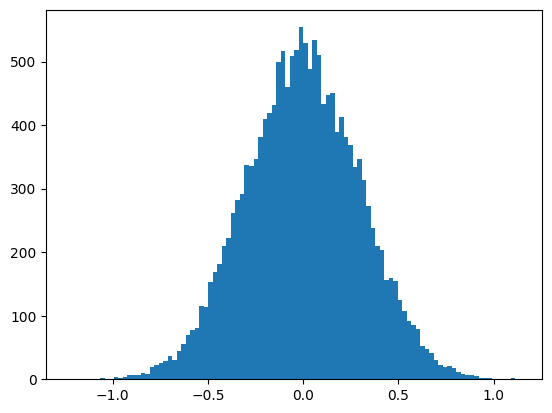

In [8]:
# from scipy.stats import beta

# # Beta distribution parameters can be tweaked for a Gaussian-like shape
# alpha, beta_param = 8, 8
# samples = beta(alpha, beta_param).rvs(1000)

# # Rescale to [-1, 1]
# bounded_samples = 2 * samples - 0.9
# print(bounded_samples.shape)
# _ = plt.hist(bounded_samples.flatten(),bins=100)


random = np.random.normal(0, 0.3, (512, 32))
_ = plt.hist(random.flatten(), bins=100)

In [9]:
random_fid = parmar_fid(random, gt_x1)
print(random_fid)

3.64562124110458


In [10]:
parmar_fid(random, gt_x2)

3.6613143722900707

# Unconditional generation performance

# Amass Conditional FID

In [13]:
from cheap.pretrained import CHEAP_pfam_shorten_2_dim_32
cheap_pipeline = CHEAP_pfam_shorten_2_dim_32()

/homefs/home/lux70/code/cheap-proteins/src/cheap/pretrained.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_fpath)


Using tanh layer at bottleneck...
Finished loading HPCT model with shorten factor 2 and 32 channel dimensions.
Creating ESMFold embedding only model...
ESMFold embedding only model created in 30.28 seconds


In [14]:
from plaid.evaluation import ConditionalFID
from pathlib import Path
import glob
import numpy as np
import torch
import os

samples_dir = Path("/data/lux70/plaid/artifacts/samples/5j007z42/ddim/5j007z42")

In [15]:
def cond_code_to_idx(cond_code: str):
    vals = cond_code.split("_")
    return int(vals[0][1:]), int(vals[1][1:])


condgen_to_true = {}
uncond_to_true = {}

batch_size = 128


for i, cond_code in enumerate(os.listdir(samples_dir)):
    function_idx, organism_idx = cond_code_to_idx(cond_code)
    # timestamps = glob.glob(str(samples_dir / cond_code / "*.npz"))
    timestamps = os.listdir(samples_dir / cond_code)
    
    if len(timestamps) > 0:
        try:
            timestamp = timestamps[-1]
            fpath = samples_dir / cond_code / timestamp / "latent.npz"
            print(fpath)
    
            cond_fid = ConditionalFID(
                function_idx=function_idx,
                organism_idx=organism_idx,
                cheap_pipeline=cheap_pipeline,
                batch_size=batch_size,
                max_seq_len=256,
                max_eval_samples=512
            )
            
            with np.load(fpath, allow_pickle=True) as f:
                x = f['samples'].astype(np.float32)
    
            feat = x[:, -1, :, :] # take last timestep only
            feat = feat.mean(axis=1)
            res = cond_fid.run(feat)
            print(cond_code, "Generated <-> GT FID:", res)
    
            condgen_to_true[cond_code] = res
    
            # also try what happens if you do ground truth unconditional to conditional
            # res = parmar_fid(feat, gt_x1)
            res = parmar_fid(cond_fid.real, gt_x1)
            uncond_to_true[cond_code] = res
            print(cond_code, "Random Real <-> GT FID:", res)
        except Exception as e:
            print(e)
            continue
            
    else:
        pass

/data/lux70/plaid/artifacts/samples/5j007z42/ddim/5j007z42/f15_o3617/240917_0643/latent.npz
Found 929 samples for this condition.
f15_o3617 Generated <-> GT FID: 0.30754982388818625
f15_o3617 Random Real <-> GT FID: 0.29848497815435426
/data/lux70/plaid/artifacts/samples/5j007z42/ddim/5j007z42/f38_o3617/240917_0854/latent.npz
Found 82105 samples for this condition.
f38_o3617 Generated <-> GT FID: 0.2347917528651
f38_o3617 Random Real <-> GT FID: 0.27184801799086106
/data/lux70/plaid/artifacts/samples/5j007z42/ddim/5j007z42/f76_o3617/240917_0900/latent.npz
Found 53163 samples for this condition.
f76_o3617 Generated <-> GT FID: 0.6581346693340275
f76_o3617 Random Real <-> GT FID: 0.3955510940668078
/data/lux70/plaid/artifacts/samples/5j007z42/ddim/5j007z42/f395_o3617/240918_2102/latent.npz
Found 4468 samples for this condition.
f395_o3617 Generated <-> GT FID: 0.5546692321421659
f395_o3617 Random Real <-> GT FID: 0.3123751249502064
/data/lux70/plaid/artifacts/samples/5j007z42/ddim/5j007z

# Plot

In [16]:
# turn into dataframe
df1 = pd.DataFrame(list(condgen_to_true.items()), columns=['Key', 'condgen_to_true'])
df2 = pd.DataFrame(list(uncond_to_true.items()), columns=['Key', 'uncond_to_true'])
combined_df = pd.merge(df1, df2, on='Key')
combined_df["GO_idx"] = combined_df['Key'].map(lambda x: cond_code_to_idx(x)[0])
combined_df["organism_index"] = combined_df['Key'].map(lambda x: cond_code_to_idx(x)[1])

# attach GO metadata
go_df = pd.read_csv("/data/lux70/data/pfam/go_index.csv")
combined_df = combined_df.merge(go_df)
combined_df = combined_df.sort_values(by="count")
combined_df['delta'] = combined_df.condgen_to_true - combined_df.uncond_to_true

In [17]:
combined_df

,Key,condgen_to_true,uncond_to_true,GO_idx,organism_index,Unnamed: 0,GO_term,pfam_id,GO_id,GO_level,count,delta
12,f1800_o3617,0.733486,0.512119,1800,3617,2050,thiamine transmembrane transporter activity,PF09515,GO:0015234,function,1,0.221367
10,f352_o3617,0.572457,0.380668,352,3617,1761,recognition of pollen,PF00954,GO:0048544,process,1,0.191790
23,f314_o3617,0.473897,0.473504,314,3617,1805,regulation of microtubule polymerization or de...,PF00836,GO:0031110,process,1,0.000393
16,f1161_o3617,0.379834,0.226352,1161,3617,2048,thiamine diphosphokinase activity,PF04263,GO:0004788,function,1,0.153482
22,f950_o3617,0.885004,0.486330,950,3617,415,amino acid transmembrane transport,PF03222,GO:0003333,process,1,0.398674
24,f146_o3617,0.577641,0.352985,146,3617,137,DNA-binding transcription activator activity,PF00309,GO:0001216,function,2,0.224655
2,f76_o3617,0.658135,0.395551,76,3617,139,"DNA-binding transcription factor activity, RNA...",PF00172,GO:0000981,function,2,0.262584
11,f192_o3617,0.188814,0.241497,192,3617,1633,protein deubiquitination,PF00443,GO:0016579,process,3,-0.052682
21,f124_o3617,0.514993,0.234110,124,3617,2060,thymidine kinase activity,PF00265,GO:0004797,function,3,0.280883
29,f287_o3617,0.550832,0.293292,287,3617,2017,tRNA aminoacylation,PF00749,GO:0043039,process,3,0.257540


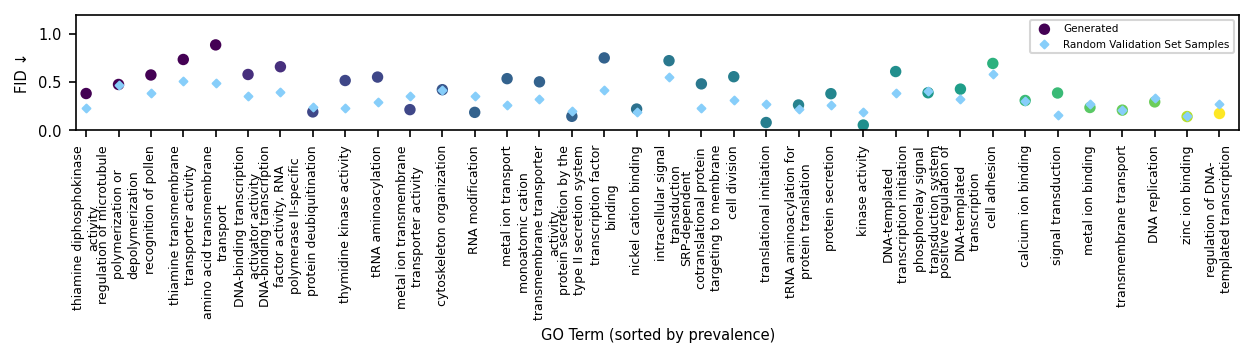

In [73]:
import textwrap
plt.rcParams['font.size'] = 7

from matplotlib import cm
from matplotlib.colors import Normalize

values = np.log(combined_df['count'])
norm = Normalize(vmin=min(values), vmax=max(values))

combined_df = combined_df.sort_values(by="condgen_to_true")
combined_df = combined_df.sort_values(by="count")

colormap = cm.viridis  # You can replace 'viridis' with any other matplotlib colormap
colors = colormap(norm(values))


fig, ax = plt.subplots(1, 1, dpi=150, figsize=(10,1))
ax.scatter(np.arange(len(combined_df)), combined_df['condgen_to_true'].values, label="Generated", s=20, c=colors)
# ax.scatter(np.arange(len(combined_df)), combined_df['uncond_to_true'].values, label="Random Validation Set Samples",s=15, c=colors, marker="D")
ax.scatter(np.arange(len(combined_df)), combined_df['uncond_to_true'].values, label="Random Validation Set Samples",s=7, c="lightskyblue", marker="D")

ax.set_xlim(-0.3, len(combined_df) - 0.4)

x_labels = combined_df.GO_term.values
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=25)) for label in x_labels]

ax.set_xticks(ticks=np.arange(len(combined_df)), labels=wrapped_labels, rotation=90, fontsize=6)

# ax.axhline(y=uncond_gt_fid, color='green', linestyle='--', label="Natural Proteins")
# ax.axhline(y=uncond_gen_fid, color='orange', linestyle='--', label="Unconditional FID")


### TODO: modify upper bound on y lim as needed
### TODO: wrap text?

ax.set_ylim(0,1.2)
ax.set_xlabel("GO Term (sorted by prevalence)")
ax.set_ylabel("FID ↓")

plt.legend(fontsize=5)

Text(0, 0.5, 'FID ↓')

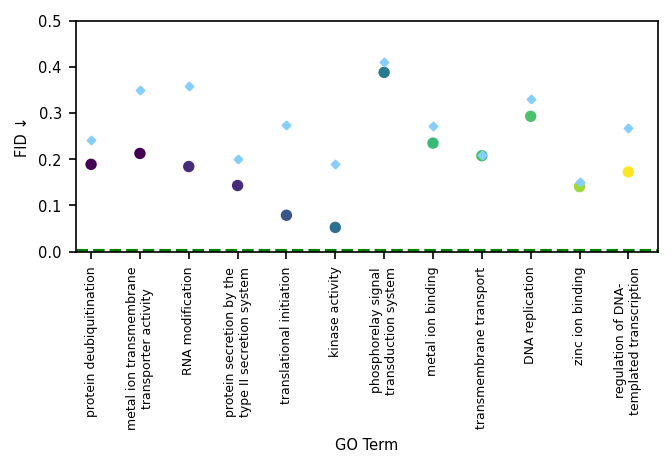

In [83]:
import textwrap
plt.rcParams['font.size'] = 7

from matplotlib import cm
from matplotlib.colors import Normalize

tmp = combined_df.copy()
tmp = tmp[tmp.delta < 0]

values = np.log(tmp['count'])
norm = Normalize(vmin=min(values), vmax=max(values))

tmp = tmp.sort_values(by="condgen_to_true")
tmp = tmp.sort_values(by="count")


colormap = cm.viridis  # You can replace 'viridis' with any other matplotlib colormap
colors = colormap(norm(values))


fig, ax = plt.subplots(1, 1, dpi=150, figsize=(5,2))
ax.scatter(np.arange(len(tmp)), tmp['condgen_to_true'].values, label="Generated", s=20, c=colors)
# ax.scatter(np.arange(len(tmp)), tmp['uncond_to_true'].values, label="Random Validation Set Samples",s=15, c=colors, marker="D")
ax.scatter(np.arange(len(tmp)), tmp['uncond_to_true'].values, label="Random Validation Set Samples",s=7, c="lightskyblue", marker="D")

ax.set_xlim(-0.3, len(tmp) - 0.4)

x_labels = tmp.GO_term.values
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=25)) for label in x_labels]

ax.set_xticks(ticks=np.arange(len(tmp)), labels=wrapped_labels, rotation=90, fontsize=6)

ax.axhline(y=uncond_gt_fid, color='green', linestyle='--', label="Natural Proteins")
#x.axhline(y=uncond_gen_fid, color='orange', linestyle='--', label="Unconditional FID")


### TODO: modify upper bound on y lim as needed
### TODO: wrap text?

ax.set_ylim(0,0.5)
ax.set_xlabel("GO Term")
ax.set_ylabel("FID ↓")

#plt.legend(fontsize=5)

In [60]:
" ".join(combined_df[combined_df.delta < 0].Key.values)

'f192_o3617 f547_o3617 f319_o3617 f434_o3617 f269_o3617 f169_o3617 f29_o3617 f38_o3617 f151_o3617 f300_o3617 f229_o3617 f86_o3617'

In [61]:
print(combined_df[combined_df.delta < 0.].GO_term.values)
print(combined_df[combined_df.delta < 0.].GO_idx.values)

['protein deubiquitination' 'metal ion transmembrane transporter activity'
 'RNA modification' 'protein secretion by the type II secretion system'
 'translational initiation' 'kinase activity'
 'phosphorelay signal transduction system' 'metal ion binding'
 'transmembrane transport' 'DNA replication' 'zinc ion binding'
 'regulation of DNA-templated transcription']
[192 547 319 434 269 169  29  38 151 300 229  86]


In [63]:
combined_df.to_csv("~/cond_fid_tmp2.csv", sep=",")